[learning_curve] Training set sizes: [ 1440  2880  4320  5760  7200  8640 10080 11520 12960 14400]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.7s finished


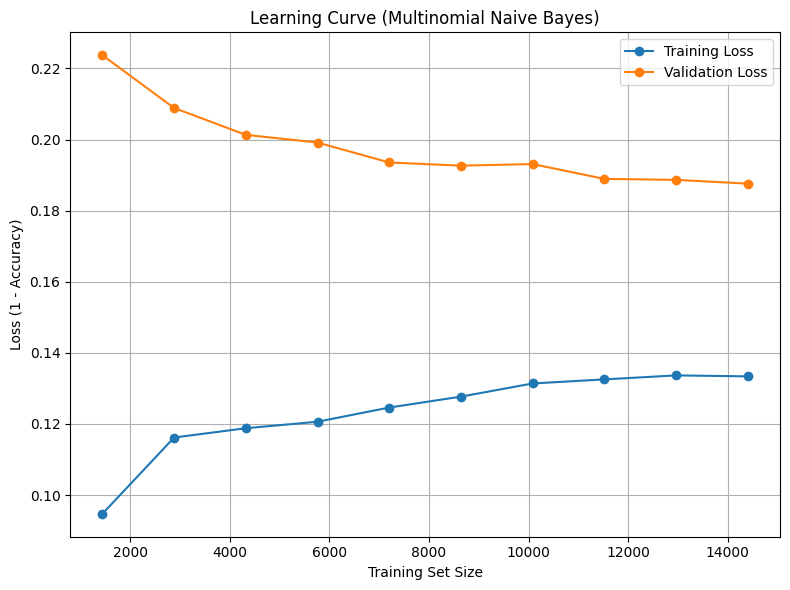


Test Accuracy: 0.8215
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1008
           1       0.84      0.79      0.81       992

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



In [9]:
# =============================
# 📦 Imports
# =============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, classification_report

# =============================
# Data Preparation
# =============================

# Load cleaned dataset
data_df = pd.read_csv("C:/Users/imand/Desktop/Achia/year3 sem1/TextAnalysis/clean_data.csv")

# Use a smaller sample for efficiency (adjust as needed)
data_df = data_df.sample(n=20000, random_state=1).reset_index(drop=True)

# Clean the Rating column
data_df['Rating'] = pd.to_numeric(data_df['Rating'], errors='coerce')
data_df = data_df.dropna(subset=['Rating'])
data_df['Rating'] = data_df['Rating'].astype(int)

# Train-test split
train_df = data_df.iloc[:18000].reset_index(drop=True)
test_df = data_df.iloc[18000:].reset_index(drop=True)

# Ensure text columns are strings and fill missing values
for col in ['Title', 'Review']:
    train_df[col] = train_df[col].fillna('').astype(str)
    test_df[col] = test_df[col].fillna('').astype(str)

X_train = train_df[['Title', 'Review']]
y_train = train_df['Rating']

X_test = test_df[['Title', 'Review']]
y_test = test_df['Rating']

# =============================
# Pipeline Setup
# =============================

# Extract Title and Review
get_title = FunctionTransformer(lambda x: x['Title'], validate=False)
get_review = FunctionTransformer(lambda x: x['Review'], validate=False)

# Title pipeline
title_pipeline = Pipeline([
    ('selector', get_title),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])

# Review pipeline
review_pipeline = Pipeline([
    ('selector', get_review),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])

# Combine both
combined_features = FeatureUnion(
    transformer_list=[
        ('title', title_pipeline),
        ('review', review_pipeline)
    ],
    transformer_weights={
        'title': 0.2,
        'review': 0.8
    }
)

# Final pipeline with Multinomial Naive Bayes
pipeline = Pipeline([
    ('features', combined_features),
    ('mnb', MultinomialNB())
])

# =============================
# Generate Learning Curve
# =============================

train_sizes, train_scores, val_scores = learning_curve(
    pipeline,
    X_train,
    y_train,
    cv=5,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy',
    verbose=1
)

# Compute mean losses
train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_loss = 1 - train_scores_mean
val_loss = 1 - val_scores_mean

# =============================
# 📊 Plot Learning Curve
# =============================

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_loss, 'o-', label='Training Loss')
plt.plot(train_sizes, val_loss, 'o-', label='Validation Loss')
plt.xlabel('Training Set Size')
plt.ylabel('Loss (1 - Accuracy)')
plt.title('Learning Curve (Multinomial Naive Bayes)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.metrics import accuracy_score, classification_report

# 1. Train the pipeline
pipeline.fit(X_train, y_train)

# 2. Predict on test data
y_pred = pipeline.predict(X_test)

# 3. Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))


### After Hyperparameter Tuning


Test Accuracy (Before Tuning): 0.8215
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      1008
           1       0.84      0.79      0.81       992

    accuracy                           0.82      2000
   macro avg       0.82      0.82      0.82      2000
weighted avg       0.82      0.82      0.82      2000



Grid Search Progress:   0%|          | 0/150 [00:00<?, ?it/s]

Fitting 3 folds for each of 50 candidates, totalling 150 fits


100%|██████████| 150/150 [00:23<00:00,  6.42it/s]



Best Parameters: {'features__transformer_weights': {'title': 0.3, 'review': 0.7}, 'mnb__alpha': 1.0, 'mnb__fit_prior': False}
Best Cross-Validation Accuracy: 0.823111111111111

Test Accuracy (Best Model): 0.8305
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      1008
           1       0.84      0.82      0.83       992

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



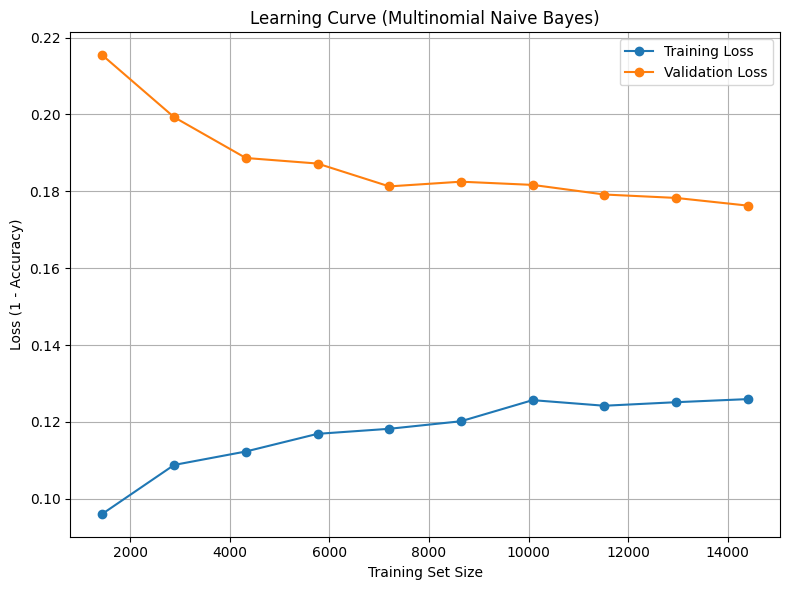

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import learning_curve, GridSearchCV
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib

# =======================
# Data Preparation 
# =======================

data_df = pd.read_csv("C:/Users/imand/Desktop/Achia/year3 sem1/TextAnalysis/clean_data.csv")

data_df['Rating'] = pd.to_numeric(data_df['Rating'], errors='coerce')
data_df = data_df.dropna(subset=['Rating'])
data_df['Rating'] = data_df['Rating'].astype(int)

data_df = data_df.sample(n=20000, random_state=1).reset_index(drop=True)

train_df = data_df.iloc[:18000].reset_index(drop=True)
test_df = data_df.iloc[18000:].reset_index(drop=True)

for col in ['Title', 'Review']:
    train_df[col] = train_df[col].fillna('').astype(str)
    test_df[col] = test_df[col].fillna('').astype(str)

X_train = train_df[['Title', 'Review']]
y_train = train_df['Rating']
X_test = test_df[['Title', 'Review']]
y_test = test_df['Rating']

# =======================
# Pipeline Construction
# =======================

get_title = FunctionTransformer(lambda x: x['Title'], validate=False)
get_review = FunctionTransformer(lambda x: x['Review'], validate=False)

title_pipeline = Pipeline([
    ('selector', get_title),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])
review_pipeline = Pipeline([
    ('selector', get_review),
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5))
])

combined_features = FeatureUnion(
    transformer_list=[
        ('title', title_pipeline),
        ('review', review_pipeline)
    ],
    transformer_weights={'title': 0.2, 'review': 0.8}
)

pipeline = Pipeline([
    ('features', combined_features),
    ('mnb', MultinomialNB())
])

# =======================
# Before Tuning Evaluation
# =======================

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("\nTest Accuracy (Before Tuning):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# =======================
# Grid Search
# =======================

param_grid = {
    'mnb__alpha': [0.01, 0.1, 0.5, 1.0, 2.0],
    'mnb__fit_prior': [True, False],
    'features__transformer_weights': [
        {'title': 0.1, 'review': 0.9},
        {'title': 0.3, 'review': 0.7},
        {'title': 0.5, 'review': 0.5},
        {'title': 0.7, 'review': 0.3},
        {'title': 0.9, 'review': 0.1}
    ]
}

total_fits = len(param_grid['mnb__alpha']) * len(param_grid['mnb__fit_prior']) * len(param_grid['features__transformer_weights']) * 3

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

with tqdm_joblib(tqdm(desc="Grid Search Progress", total=total_fits)):
    grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest Accuracy (Best Model):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# =======================
# Learning Curve
# =======================

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train,
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)

train_loss = 1 - train_scores_mean
val_loss = 1 - val_scores_mean

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_loss, 'o-', label="Training Loss")
plt.plot(train_sizes, val_loss, 'o-', label="Validation Loss")
plt.xlabel("Training Set Size")
plt.ylabel("Loss (1 - Accuracy)")
plt.title("Learning Curve (Multinomial Naive Bayes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
